In [59]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

import bemcs
import labeling

# define els_obs as an object containing x_normals and y_normals with same as size as n_pts
class els_normals:
    def __init__(self, els, n_pts):
        x_normals = els.x_normals
        y_normals = els.y_normals
        x_shears = els.x_shears
        y_shears = els.y_shears

        self.x_normals = np.zeros(n_pts * len(x_normals))
        self.y_normals = np.zeros(n_pts * len(x_normals))
        self.x_normals[0:n_pts] = x_normals[0]
        self.y_normals[0:n_pts] = y_normals[0]
        self.x_normals[n_pts : 2 * n_pts] = x_normals[1]
        self.y_normals[n_pts : 2 * n_pts] = y_normals[1]

        self.x_shears = np.zeros(n_pts * len(x_normals))
        self.y_shears = np.zeros(n_pts * len(x_normals))
        self.x_shears[0:n_pts] = x_shears[0]
        self.y_shears[0:n_pts] = y_shears[0]
        self.x_shears[n_pts : 2 * n_pts] = x_shears[1]
        self.y_shears[n_pts : 2 * n_pts] = y_shears[1]


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Example 1: Right angle step
Consider a 3-element fault that meets only at right angles, and we impose slip on the node centers.

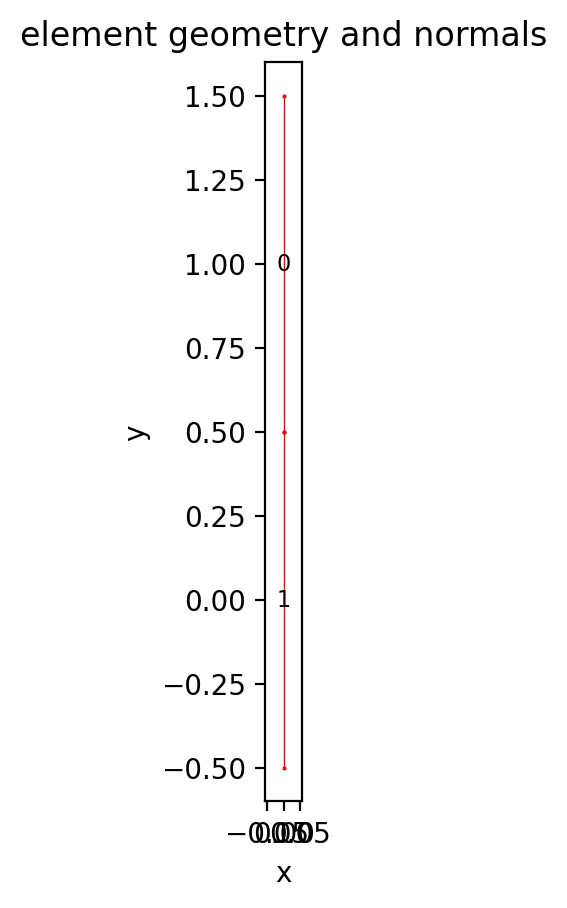

Number of open nodes = 2
: [array([3]), array([0])]
Number of 2-overlap nodes = 1
: [array([-2, -5])]
Number of triple junctions = 0
: []


In [60]:
els = bemcs.initialize_els()

# setup a vertical fault with nodes ordered "the correct" way
# els.x1 = np.array([0.0, 0.0])
# els.y1 = np.array([1.5, 0.5])
# els.x2 = np.array([0.0, 0.0])
# els.y2 = np.array([0.5, -0.5])

# this is a vertical fault where the fault end points are ordered the "other" way
els.x1 = np.array([0.0, 0.0])
els.y1 = np.array([1.5, -0.5])
els.x2 = np.array([0.0, 0.0])
els.y2 = np.array([0.5, 0.5])

bemcs.standardize_els_geometry(els)
n_els = len(els.x1)
bemcs.plot_els_geometry(els)

index_open, index_overlap, index_triple = labeling.label_nodes(els)
N_c = 2 * n_els  # central node equations
N_o = 2 * len(index_open)  # open node equations
N_i = 4 * len(index_overlap)  # overlapping node equations


# Imposed slip (specified in $x,y$ direction)

In [61]:
# Slip imposed at central nodes of each patch (these are in x,y coordinates)
slip_vector_x = np.array([0.5, 0.0])
slip_vector_y = np.array([0.0, 0.5])
Nequations = N_c + N_o + N_i
Nunknowns = 6 * n_els

# We will stack this with
# equations for the element centers
# equations at open nodes (RHS = 0)
# equations at overlapping nodes (RHS = 0)
BC_c = np.zeros((N_c, 1))  # these are the only non-zero entries
BC_o = np.zeros((N_o, 1))
BC_i = np.zeros((N_i, 1))

# apply BCs at central nodes
BC_c[0::2, 0] = slip_vector_x
BC_c[1::2, 0] = slip_vector_y

# stack all the BCs into 1 big vector
BCvector = np.vstack((BC_c, BC_o, BC_i))

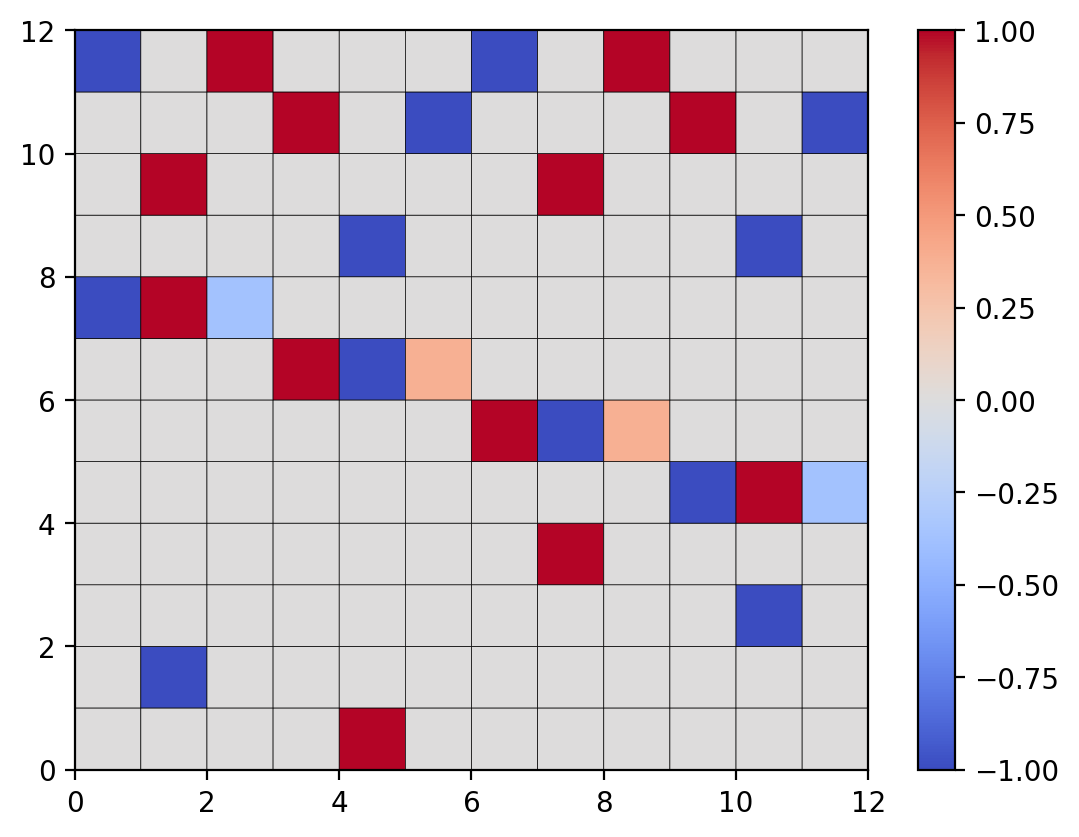

In [62]:
# Design matrices (in x, y coordinates) for slip and slip gradients at each 3qn
stride = 6
slip_mat, slip_gradient_mat = bemcs.get_matrices_slip_slip_gradient(els, flag="node")

# Linear Operators for the appropriate boundary conditions
matrix_system_c = np.zeros((N_c, Nunknowns))
# populate matrix_system for central nodes
matrix_system_c[0::2, :] = slip_mat[2::6, :]
matrix_system_c[1::2, :] = slip_mat[3::6, :]

matrix_system_o, matrix_system_i, matrix_system_t = labeling.construct_smoothoperator(
    els, index_open, index_overlap, index_triple
)

# stack the matrices and create the full linear operator
matrix_system = np.vstack(
    (matrix_system_c, matrix_system_o, matrix_system_i, matrix_system_t)
)

plt.figure()
plt.pcolor(matrix_system, cmap="coolwarm", edgecolors="k")
plt.colorbar()
plt.clim(-1, 1)
plt.show()

# Solve for quadratic node coefficients (in local (s, n) coordinates)
coeffs = np.linalg.pinv(matrix_system) @ BCvector.reshape(-1)

# Extract (s, n) components and store them in two separate vectors
coeffs_s = np.zeros((3 * n_els))
coeffs_n = np.zeros((3 * n_els))
for i in range(n_els):
    coeffs_s[3 * i : 3 * (i + 1)] = coeffs[stride * i : stride * i + 3]
    coeffs_n[3 * i : 3 * (i + 1)] = coeffs[stride * i + 3 : stride * (i + 1)]

# Plot displacements and stresses

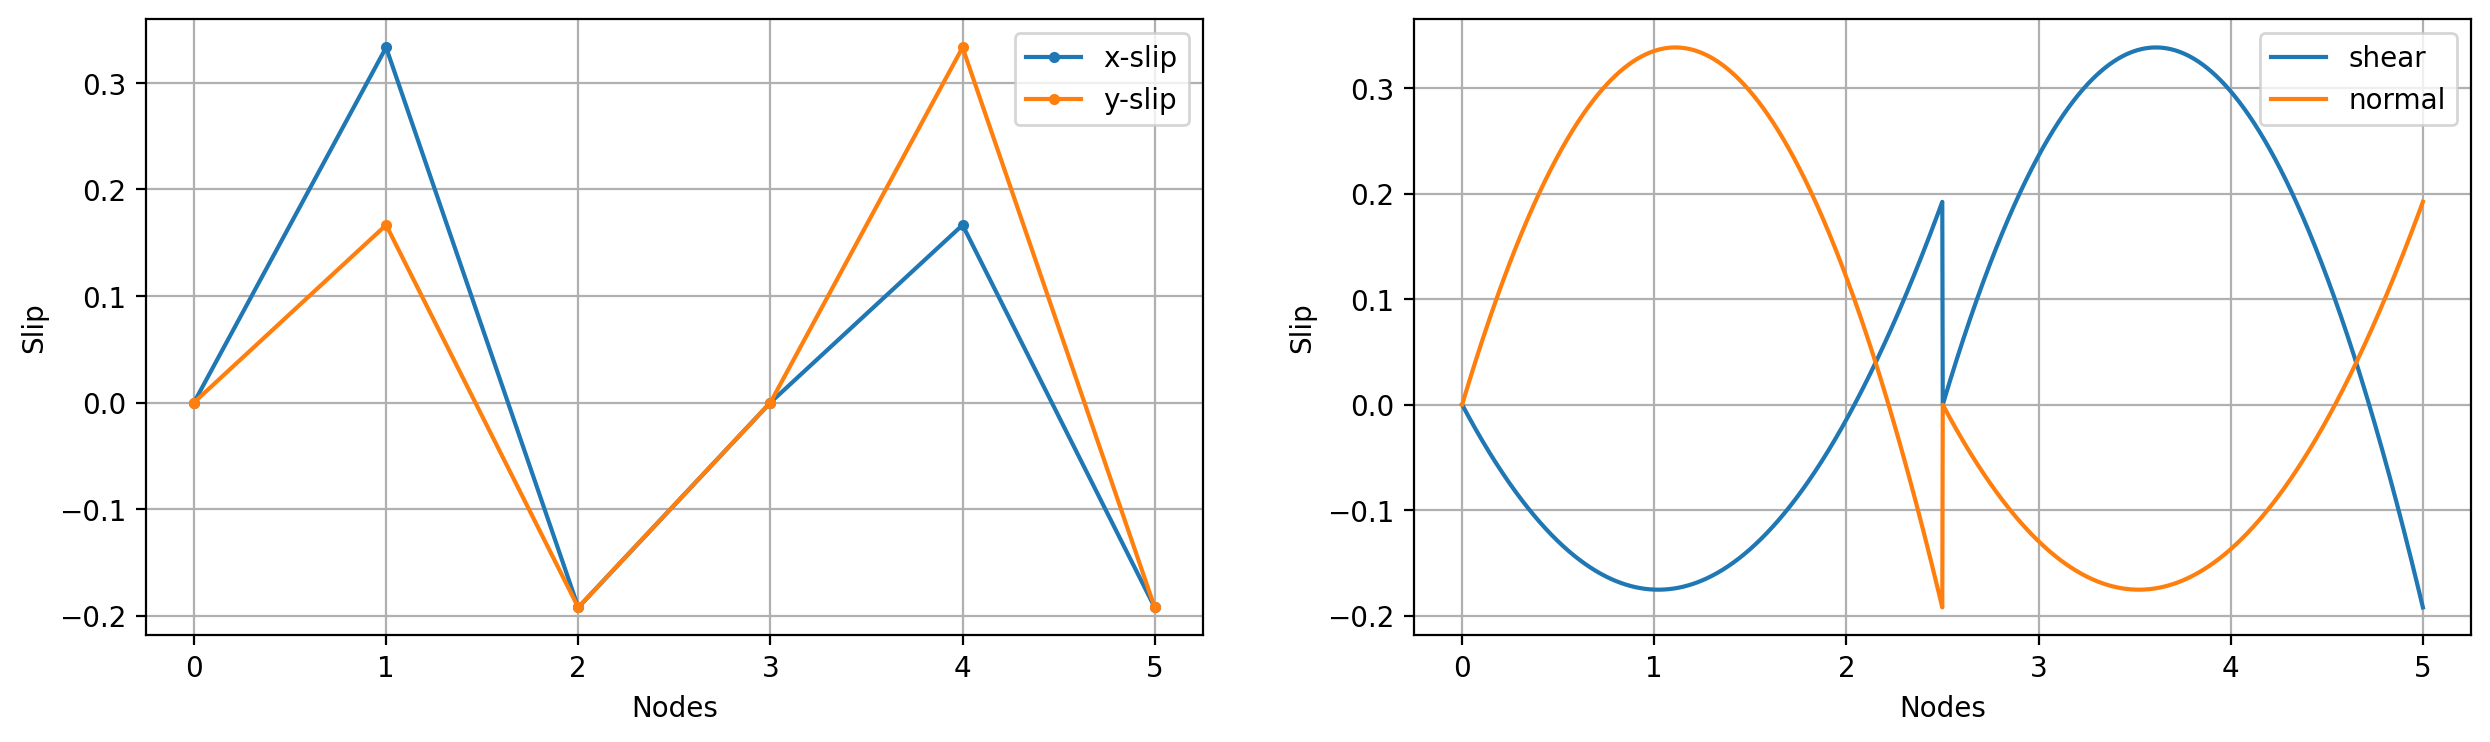

[[ 3.88578059e-16  2.77555756e-17]
 [ 3.33333333e-01  1.66666667e-01]
 [-1.92307692e-01 -1.92307692e-01]
 [ 3.33066907e-16 -4.44089210e-16]
 [ 1.66666667e-01  3.33333333e-01]
 [-1.92307692e-01 -1.92307692e-01]]


In [63]:
n_eval = 1000
fault_slip_s = np.zeros(n_els * n_eval)
fault_slip_n = np.zeros(n_els * n_eval)
for i in range(n_els):
    xdummy = np.linspace(-0.5, 0.5, n_eval)
    fault_slip_s[i * n_eval : (i + 1) * n_eval] = (
        bemcs.slip_functions(xdummy, 0.5) @ coeffs_s[3 * i : 3 * (i + 1)]
    )
    fault_slip_n[i * n_eval : (i + 1) * n_eval] = (
        bemcs.slip_functions(xdummy, 0.5) @ coeffs_n[3 * i : 3 * (i + 1)]
    )

fault_slip = slip_mat @ coeffs
fault_slip_x = fault_slip[0::2]
fault_slip_y = fault_slip[1::2]
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(fault_slip_x, ".-", label="x-slip")
plt.plot(fault_slip_y, ".-", label="y-slip")
plt.grid()
plt.legend()
plt.xlabel("Nodes")
plt.ylabel("Slip")
plt.subplot(1, 2, 2)
plt.plot(
    np.linspace(0, 3 * n_els - 1, n_els * n_eval), fault_slip_s, "-", label="shear"
)
plt.plot(
    np.linspace(0, 3 * n_els - 1, n_els * n_eval), fault_slip_n, "-", label="normal"
)
plt.grid()
plt.legend()
plt.xlabel("Nodes")
plt.ylabel("Slip")
plt.show()

print(
    np.hstack(
        (
            (slip_mat @ coeffs).reshape(-1, 1)[0::2],
            (slip_mat @ coeffs).reshape(-1, 1)[1::2],
        )
    )
)

### Compute tractions along elements

Testing to see if tractions are continuous along the fault

Plot displacements and stresses on both sides of the fault

In [64]:
# Compute displacement and stress kernels
# Elastic parameters
mu = 1
nu = 0.25

# Compute displacements along a line
n_pts = 200
dr = 1e-8

els_obs = els_normals(els, n_pts)

x_obs_p = np.hstack(
    (
        np.linspace(els.x1[0], els.x2[0], n_pts) + dr * els.x_normals[0],
        np.linspace(els.x1[1], els.x2[1], n_pts) + dr * els.x_normals[1],
    )
).reshape(-1, 1)
y_obs_p = np.hstack(
    (
        np.linspace(els.y1[0], els.y2[0], n_pts) + dr * els.y_normals[0],
        np.linspace(els.y1[1], els.y2[1], n_pts) + dr * els.y_normals[1],
    )
).reshape(-1, 1)

x_obs_n = np.hstack(
    (
        np.linspace(els.x1[0], els.x2[0], n_pts) - dr * els.x_normals[0],
        np.linspace(els.x1[1], els.x2[1], n_pts) - dr * els.x_normals[1],
    )
).reshape(-1, 1)
y_obs_n = np.hstack(
    (
        np.linspace(els.y1[0], els.y2[0], n_pts) - dr * els.y_normals[0],
        np.linspace(els.y1[1], els.y2[1], n_pts) - dr * els.y_normals[1],
    )
).reshape(-1, 1)

# Compute shear and tensile stress kernels
kernels_s = bemcs.get_displacement_stress_kernel(
    x_obs_p, y_obs_p, els, mu, nu, flag="shear"
)
kernels_n = bemcs.get_displacement_stress_kernel(
    x_obs_p, y_obs_p, els, mu, nu, flag="normal"
)

# compute traction kernels
tractionkernels_s = bemcs.get_traction_kernels(els_obs, kernels_s, flag="global")
tractionkernels_n = bemcs.get_traction_kernels(els_obs, kernels_n, flag="global")

# displacements and stresses
ux_p, uy_p, sxx_p, syy_p, sxy_p = bemcs.coeffs_to_disp_stress(
    kernels_s, kernels_n, coeffs_s, coeffs_n
)
# tractions
tx_p = tractionkernels_s[0] @ coeffs_s + tractionkernels_n[0] @ coeffs_n
ty_p = tractionkernels_s[1] @ coeffs_s + tractionkernels_n[1] @ coeffs_n


# Compute shear and tensile stress kernels
kernels_s = bemcs.get_displacement_stress_kernel(
    x_obs_n, y_obs_n, els, mu, nu, flag="shear"
)
kernels_n = bemcs.get_displacement_stress_kernel(
    x_obs_n, y_obs_n, els, mu, nu, flag="normal"
)

# compute traction kernels
tractionkernels_s = bemcs.get_traction_kernels(els_obs, kernels_s, flag="global")
tractionkernels_n = bemcs.get_traction_kernels(els_obs, kernels_n, flag="global")

# displacements and stresses
ux_n, uy_n, sxx_n, syy_n, sxy_n = bemcs.coeffs_to_disp_stress(
    kernels_s, kernels_n, coeffs_s, coeffs_n
)
# tractions
tx_n = tractionkernels_s[0] @ coeffs_s + tractionkernels_n[0] @ coeffs_n
ty_n = tractionkernels_s[1] @ coeffs_s + tractionkernels_n[1] @ coeffs_n

# Plot results

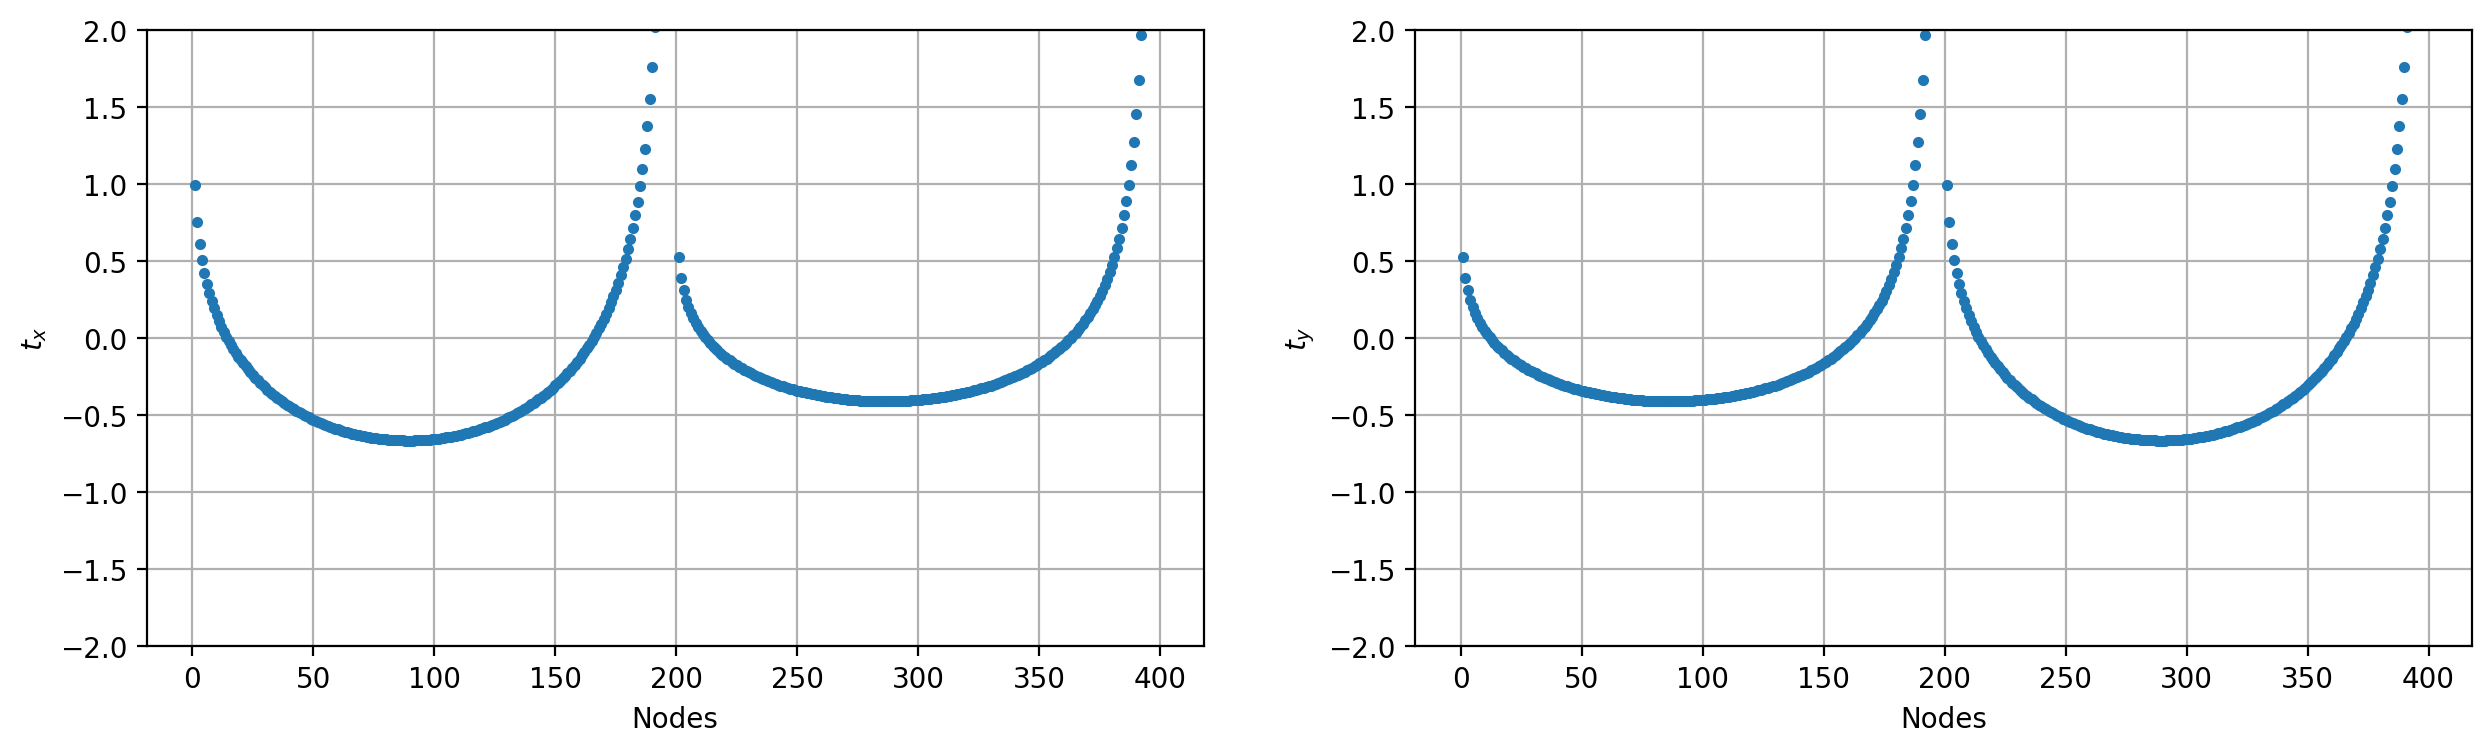

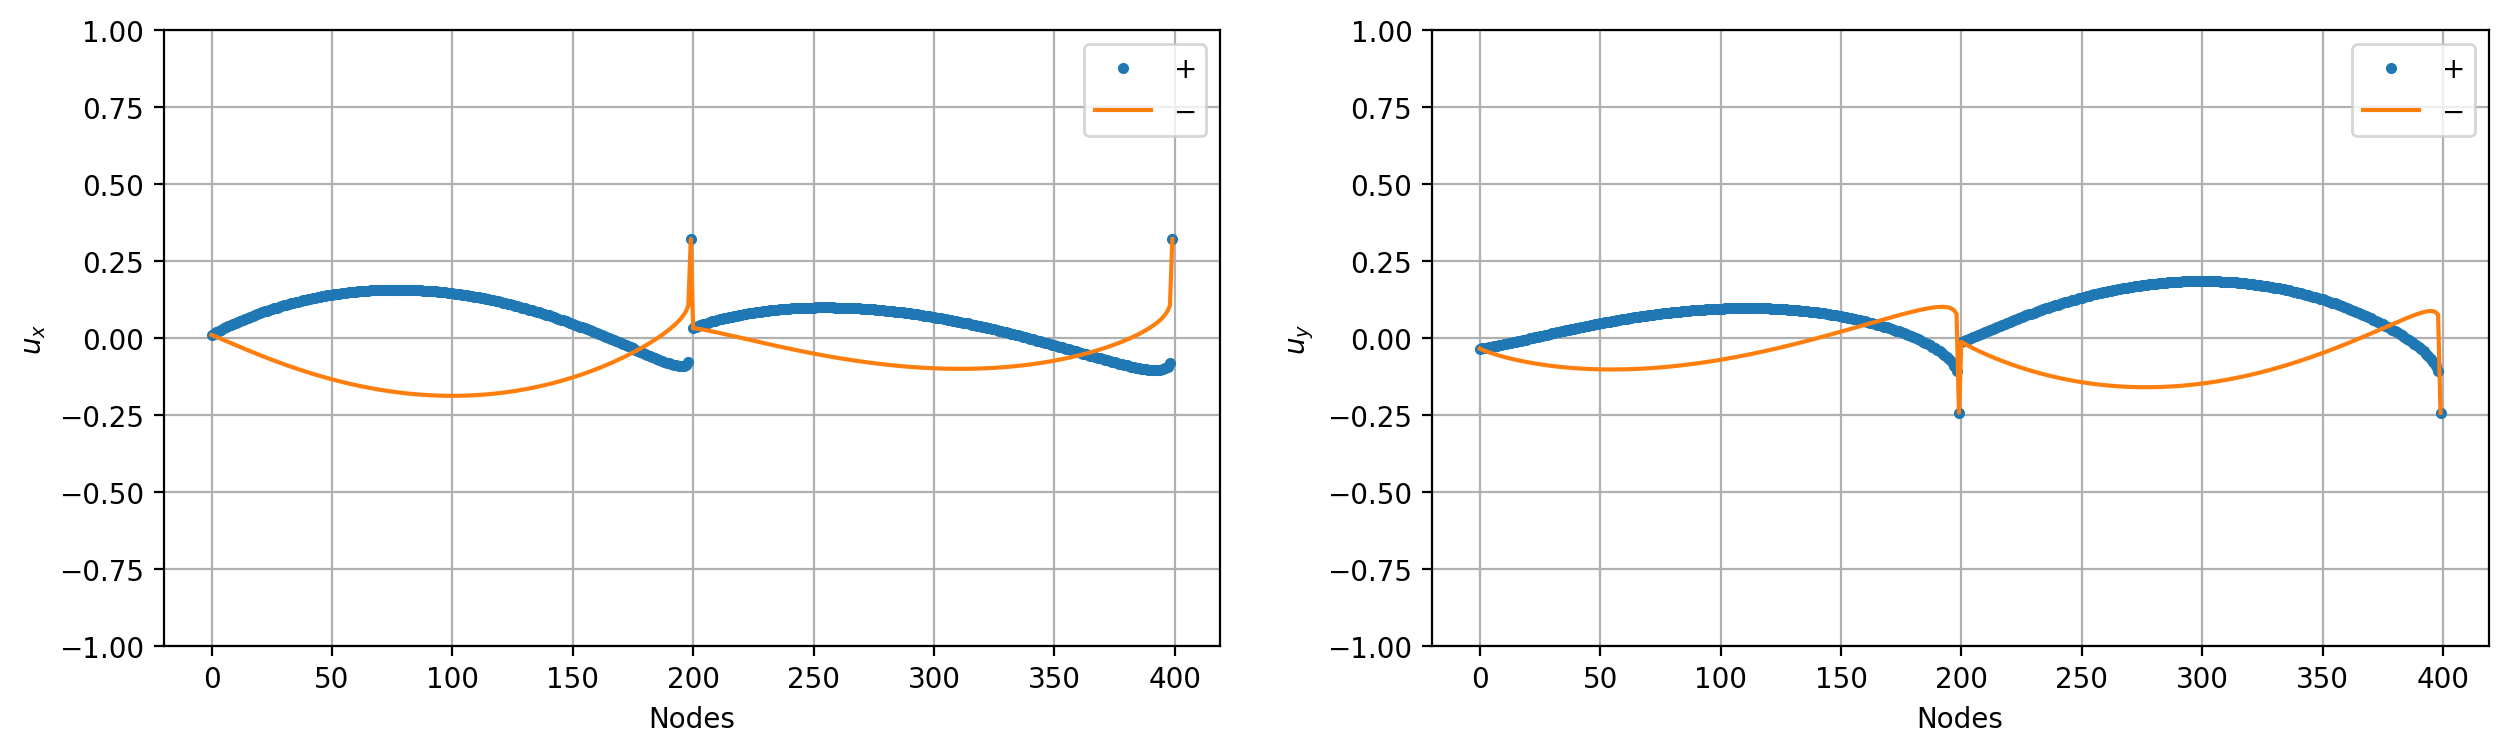

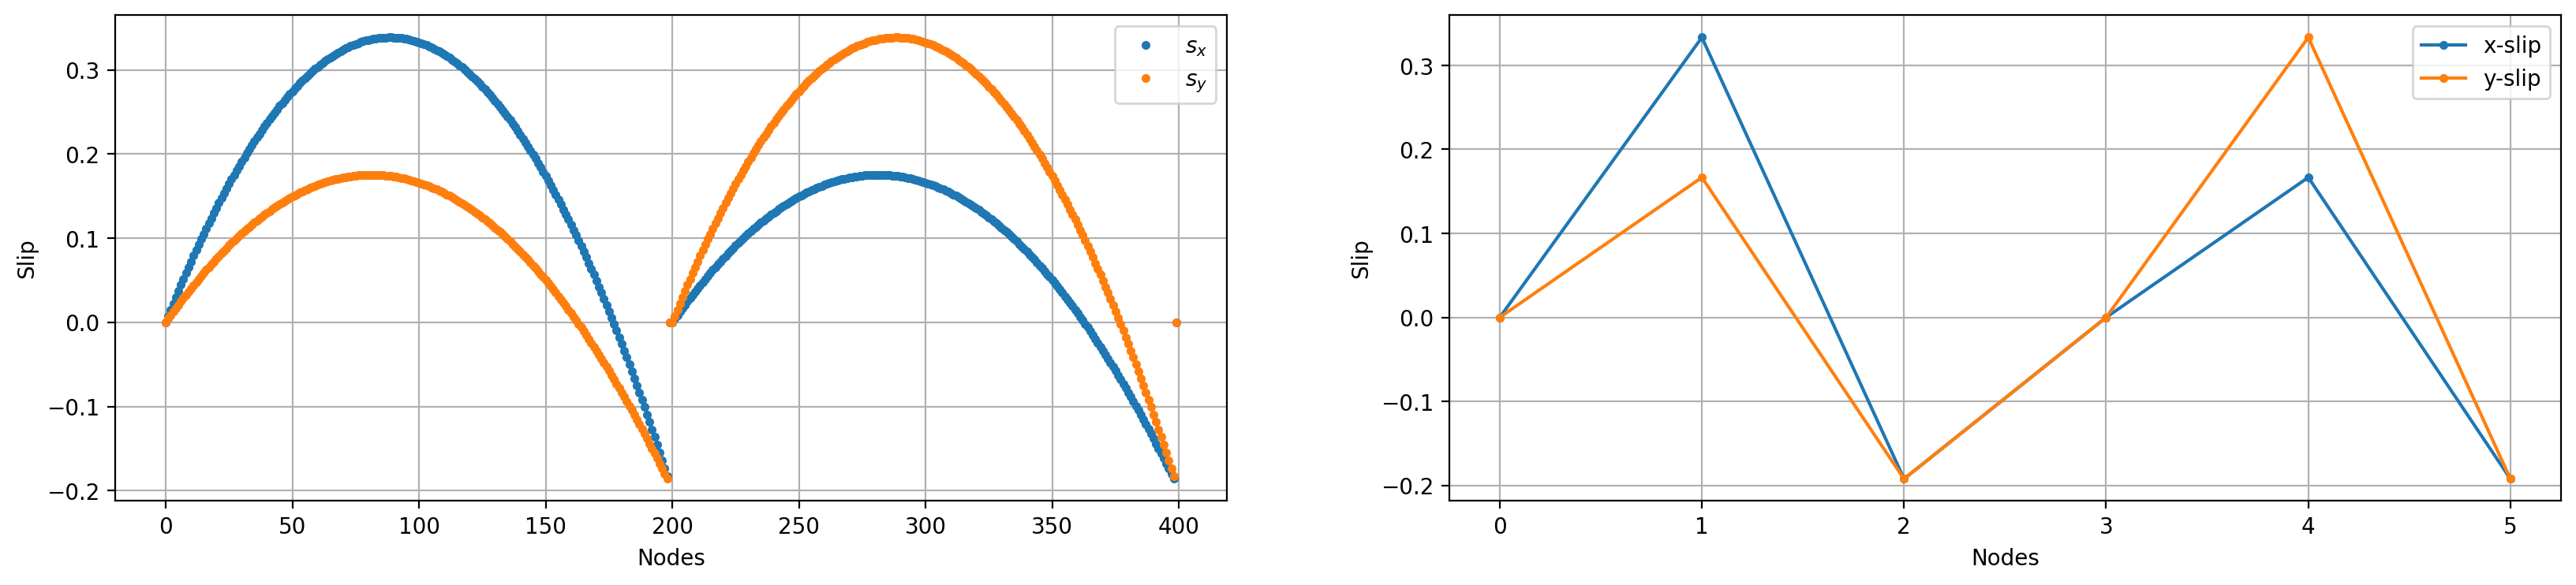

In [65]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(tx_p, ".")
plt.grid()
plt.xlabel("Nodes")
plt.ylabel("$t_x$")
plt.ylim(-2, 2)
plt.subplot(1, 2, 2)
plt.plot(ty_p, ".")
plt.grid()
plt.xlabel("Nodes")
plt.ylabel("$t_y$")
plt.ylim(-2, 2)
plt.show()

plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(ux_p, ".", label="$+$")
plt.plot(ux_n, "-", label="$-$")
plt.grid()
plt.legend()
plt.ylim(-1, 1)
plt.xlabel("Nodes")
plt.ylabel("$u_x$")
plt.subplot(1, 2, 2)
plt.plot(uy_p, ".", label="$+$")
plt.plot(uy_n, "-", label="$-$")
plt.grid()
plt.legend()
plt.ylim(-1, 1)
plt.xlabel("Nodes")
plt.ylabel("$u_y$")
plt.show()

plt.figure(figsize=(20, 4))
plt.subplot(1, 2, 1)
plt.plot(ux_p - ux_n, ".", label="$s_x$")
plt.plot(uy_p - uy_n, ".", label="$s_y$")
plt.grid()
plt.legend()
plt.xlabel("Nodes")
plt.ylabel("Slip")
plt.subplot(1, 2, 2)
plt.plot(fault_slip_x, ".-", label="x-slip")
plt.plot(fault_slip_y, ".-", label="y-slip")
plt.grid()
plt.legend()
plt.xlabel("Nodes")
plt.ylabel("Slip")
plt.show()